In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
import rasterio as rio
from osgeo import gdal
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt

from plots import plot_heatmap
from stats_ops import ks_test_pairwise

%load_ext autoreload
%autoreload 2

# Functions

In [2]:
no_data_value = -9999
model_res = 0.01976293625031605786  # in deg, ~2 km
WestUS_shape = '../../Data_main/ref_shapes/WestUS_states.shp'
WestUS_raster = '../../Data_main/ref_rasters/Western_US_refraster_2km.tif'

def makedirs(directory_list):
    """
    Make directory (if not exists) from a list of directory. Can create multiple directories if provided in the arg as
    a list.

    :rtype: None
    :param directory_list: A list of directories to create.

    :return: None.
    """
    for directory in directory_list:
        if not os.path.exists(directory):
            os.makedirs(directory)

def read_raster_arr_object(raster_file, rasterio_obj=False, band=1, get_file=True, change_dtype=True):
    """
    Get raster array and raster file.

    :param raster_file: Input raster filepath.
    :param rasterio_obj: Set True if raster_file is a rasterio object.
    :param band: Selected band to read. Default set to 1.
    :param get_file: Set to False if raster file is not required.
    :param change_dtype: Set to True if want to change raster data type to float. Default set to True.

    :return: Raster numpy array and rasterio object file (get_file=True, rasterio_obj=False).
    """
    if not rasterio_obj:
        raster_file = rio.open(raster_file)
    else:
        get_file = False

    raster_arr = raster_file.read(band)

    if change_dtype:
        raster_arr = raster_arr.astype(np.float32)
        if raster_file.nodata:
            raster_arr[np.isclose(raster_arr, raster_file.nodata)] = np.nan

    if get_file:
        return raster_arr, raster_file
    else:
        return raster_arr


def write_array_to_raster(raster_arr, raster_file, transform, output_path, dtype=None,
                          ref_file=None, nodata=no_data_value):
    """
    Write raster array to Geotiff format.

    :param raster_arr: Raster array data to be written.
    :param raster_file: Original rasterio raster file containing geo-coordinates.
    :param transform: Affine transformation matrix.
    :param output_path: Output filepath.
    :param dtype: Output raster data type. Default set to None.
    :param ref_file: Write output raster considering parameters from reference raster file.
    :param nodata: no_data_value set as -9999.

    :return: Output filepath.
    """
    makedirs([os.path.dirname(output_path)])

    if dtype is None:
        dtype = raster_arr.dtype

    if ref_file:
        raster_file = rio.open(ref_file)
        transform = raster_file.transform

    with rio.open(
            output_path,
            'w',
            driver='GTiff',
            height=raster_arr.shape[0],
            width=raster_arr.shape[1],
            dtype=dtype,
            count=raster_file.count,
            crs=raster_file.crs,
            transform=transform,
            nodata=nodata
    ) as dst:
        dst.write(raster_arr, raster_file.count)

    return output_path
    
def mask_raster_by_shape(input_raster, input_shape, output_dir,
                         raster_name, band_names=None,
                         crop=True, filled=True, invert=False,
                         nodata=no_data_value):
    """
    Crop/mask a raster with a given shapefile/raster's extent.

    :param input_raster: Filepath of input raster.
    :param input_shape: Filepath of shape file to crop input_raster.
    :param output_dir: Filepath of output directory.
    :param raster_name: Masked raster name.
    :param band_names: A list of band names (str) to set with the output raster. Default set to None.
    :param crop: Set to False to set no data in pixels outside shape. Only the pixels inside will have values
                 and the row and column size will be the same as input raster.
                 Default set to True. The pixels outside the shape will be discarded totally and row and column values
                 will change.
    :param invert : If False (default) pixels outside shapes will be masked.  If True,
                    pixels inside shape will be masked.
    :param filled : If True, the pixels outside the features will be set to nodata.
                    If False, the output array will contain the original pixel data,
                    and only the mask will be based on shapes.  Defaults to True.
    :param nodata: No data value. Default set to -9999.

    :return: Filepath of cropped raster.
    """
    makedirs([output_dir])

    # opening input raster
    raster_file = rio.open(input_raster)
    raster_arr = raster_file.read()

    # opening input shapefile and taking it to a GeoJSON format
    shp_extent = gpd.read_file(input_shape)
    shp_extent = shp_extent.to_crs(crs=raster_file.crs)
    geoms = [geom.__geo_interface__ for geom in shp_extent.geometry]  # GeoJSON format

    # masking
    masked_arr, mask_transform = mask(dataset=raster_file, shapes=geoms, filled=filled,
                                      crop=crop, invert=invert, all_touched=False)

    # naming output file
    makedirs([output_dir])
    output_raster = os.path.join(output_dir, raster_name)

    # saving output raster
    if band_names is not None:
        with rio.open(
                output_raster,
                'w',
                driver='GTiff',
                height=masked_arr.shape[-2],  # using reverse indexing to handle multiband rasters
                width=masked_arr.shape[-1],
                dtype=raster_arr.dtype,
                count=raster_file.count,
                crs=raster_file.crs,
                transform=mask_transform,
                nodata=nodata
        ) as dst:
            dst.write(masked_arr)
            dst.descriptions = tuple(band_names)

    else:
        with rio.open(
                output_raster,
                'w',
                driver='GTiff',
                height=masked_arr.shape[-2],  # using reverse indexing to handle multiband rasters
                width=masked_arr.shape[-1],
                dtype=raster_arr.dtype,
                count=raster_file.count,
                crs=raster_file.crs,
                transform=mask_transform,
                nodata=nodata
        ) as dst:
            dst.write(masked_arr)

    return output_raster

# Climatic water balance compilation and data extraction for each state

### Creating climatic water balance 'CWB' (RET - Precip) raster
`This need to be done only once`

In [3]:
# #################################################################################################
# # Creating climatic water balance 'CWB' (RET - Precip) raster
# ################################################################################################# 

# ret_dir = f'../../Data_main/rasters/RET/WestUS_growing_season'
# p_dir =  f'../../Data_main/rasters/Precip/WestUS_growing_season'
# output_dir = f'../../Data_main/rasters/Climate_water_balance'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for year in list(range(2000, 2024)):
#     ret, file = read_raster_arr_object(os.path.join(ret_dir, f'RET_{year}.tif'))
#     p = read_raster_arr_object(os.path.join(p_dir, f'Precip_{year}.tif'), get_file=False)

#     # calculate climate demand
#     clim_balance = np.where(~np.isnan(ret) & ~np.isnan(p), ret - p, -9999)

#     # save
#     clim_raster = os.path.join(output_dir, f'CWB_{year}.tif')
#     write_array_to_raster(clim_balance, file, file.transform, clim_raster)

### data extraction by state

In [3]:
# basins used in training + validation
basin_dict = {'KS': ['../../Data_main/shapefiles/Basins_of_interest/GMD3.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/GMD4.shp'],
              
              'CO': ['../../Data_main/shapefiles/Basins_of_interest/Republican_Basin.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/Rio_Grande_Basin.shp'],
              
              'AZ': ['../../Data_main/shapefiles/Basins_of_interest/Harquahala_INA.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/Douglas_AMA.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/SantaCruz_AMA.shp'],
              
              'NV': ['../../Data_main/shapefiles/Basins_of_interest/Diamond_Valley_Basin.shp'],
              
              'UT': ['../../Data_main/shapefiles/Basins_of_interest/Parowan_Valley.shp',
                    '../../Data_main/shapefiles/Basins_of_interest/Cedar_Valley.shp',
                    '../../Data_main/shapefiles/Basins_of_interest/Beryl_Valley.shp'],
              
              'NM': ['../../Data_main/shapefiles/Basins_of_interest/New Mexico_central_hucs.shp'],
              
              'TX': ['../../Data_main/shapefiles/Basins_of_interest/Texas_HPA_hucs.shp'],

              'OK': ['../../Data_main/shapefiles/Basins_of_interest/Oklahoma_hucs.shp']
             }


#################################################################################################
# managing shapefiles for basins of interest
#################################################################################################
for state in basin_dict.keys():
    basin_list = basin_dict[state]

    # if multiple basins are considered in a state
    if len(basin_list) > 1:
        gdf = gpd.GeoDataFrame()  # empty geodataframe to compile all basins in a state

        # merging multiple basins into one for each state
        for i in range(len(basin_list)):
            merged_gdf = pd.concat([gdf, gpd.read_file(basin_list[i])], axis=0)

            gdf = merged_gdf

        merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
        merged_gdf = merged_gdf.dissolve()

        temp_shape = 'temp.shp'
        merged_gdf.to_file(temp_shape)
        input_shape = temp_shape

    # if a single multiple basin is considered in a state
    else:
        input_shape = basin_dict[state][0]

        
#################################################################################################
# masking raster for each state's basins
#################################################################################################
    cwb_rasters = glob(os.path.join(f'../../Data_main/rasters/Climate_water_balance', '*.tif'))
    
    for ras in cwb_rasters:
        mask_raster_by_shape(input_raster=ras, input_shape=input_shape, 
                             output_dir=f'../../Data_main/rasters/Climate_water_balance/{state}',
                             raster_name = os.path.basename(ras), 
                             band_names=None,
                             crop=True, filled=True, invert=False,
                             nodata=no_data_value)
    
    # removing the temporary shapefile for the inner loop
    for f in glob(os.path.splitext(temp_shape)[0] + '.*'):
        os.remove(f)

#################################################################################################
# collecting pixel data into dataframe from masked rasters
#################################################################################################

empty_dict = {state: [] for state in basin_dict.keys()}  # empty dict to store values by state

for state in basin_dict.keys():
    basin_cwb_rasters = glob(os.path.join(f'../../Data_main/rasters/Climate_water_balance/{state}', '*.tif'))

    for ras in basin_cwb_rasters:
        arr = read_raster_arr_object(ras, get_file=False).flatten()
        arr = arr[~np.isnan(arr)]
        empty_dict[state].extend(arr)

C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 21819956149 of field Shape_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 21820149683 of field area_m2 of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Perimeter' to 'Perimete_1'
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Area' to 'Area_1'
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 980633835.28999996 of field AREA of feature 0 not successfully written. Possibly due

In [4]:
#################################################################################################
# creating separate dataframe for each state in empty_dict
#################################################################################################

# Kansas
df_ks = pd.DataFrame({'value': empty_dict['KS']})  

# Colorado
df_co = pd.DataFrame({'value': empty_dict['CO']})  

# Arizona
df_az = pd.DataFrame({'value': empty_dict['AZ']})  

# Nevada
df_nv = pd.DataFrame({'value': empty_dict['NV']})  

# Utah
df_ut = pd.DataFrame({'value': empty_dict['UT']})  

# New Mexico
df_nm = pd.DataFrame({'value': empty_dict['NM']})

# Texas
df_tx = pd.DataFrame({'value': empty_dict['TX']})

# Oklahoma
df_ok = pd.DataFrame({'value': empty_dict['OK']})

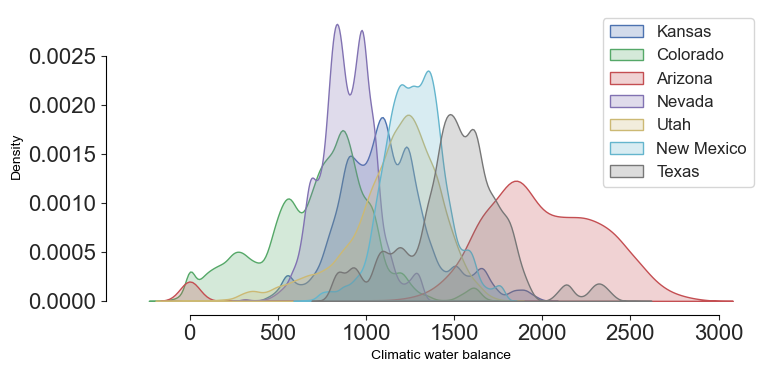

In [5]:
#################################################################################################
# plotting KDEs
#################################################################################################

fig, ax = plt.subplots(figsize=(8, 4))

sns.set_style("white")        # removes gridlines
fig.patch.set_facecolor("white")
plt.rcParams['font.size'] = '16'

# Define consistent colors
colors = {
    'Kansas': '#4C72B0',
    'Colorado': '#55A868',
    'Arizona': '#C44E52',
    'Nevada': '#8172B2',
    'Utah': '#CCB974',
    'New Mexico': '#64B5CD',
    'Texas' : "#777777"
}

# Plot KDEs
sns.kdeplot(df_ks['value'], ax=ax, fill=True, color=colors['Kansas'], label='Kansas')
sns.kdeplot(df_co['value'], ax=ax, fill=True, color=colors['Colorado'], label='Colorado')
sns.kdeplot(df_az['value'], ax=ax, fill=True, color=colors['Arizona'], label='Arizona')
sns.kdeplot(df_nv['value'], ax=ax, fill=True, color=colors['Nevada'], label='Nevada')
sns.kdeplot(df_ut['value'], ax=ax, fill=True, color=colors['Utah'], label='Utah')
sns.kdeplot(df_nm['value'], ax=ax, fill=True, color=colors['New Mexico'], label='New Mexico')
sns.kdeplot(df_tx['value'], ax=ax, fill=True, color=colors['Texas'], label='Texas')


# Labels and formatting
ax.set_xlabel('Climatic water balance')
ax.set_ylabel('Density')
# ax.set_title('Distribution of climatic water balance')
ax.tick_params(axis='both')
ax.legend(prop={'size': 12})
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

fig.savefig('../../Model_run/plots/CWB_KDE.jpg', dpi=200)

#### Why model is doing well in utah
- __Utah:__ `The model, trained on groundwater-dominated basins in Kansas, Colorado, Arizona, and Nevada, generalizes effectively to Utah because Utah’s climatic and hydrologic conditions fall within the range of the training domain. KDE of CWB show strong overlap between Utah and several training states, particularly Kansas, suggesting that Utah’s feature space is well represented by the data used for model training. Moreover, Utah primarily relies on groundwater for irrigation, matching the hydrologic mechanism learned by the model. Consequently, the model encounters little covariate shift when predicting pumping in Utah, and its transfer performance remains robust.` 

In [24]:
from plots import plot_heatmap
from stats_ops import ks_test_pairwise


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


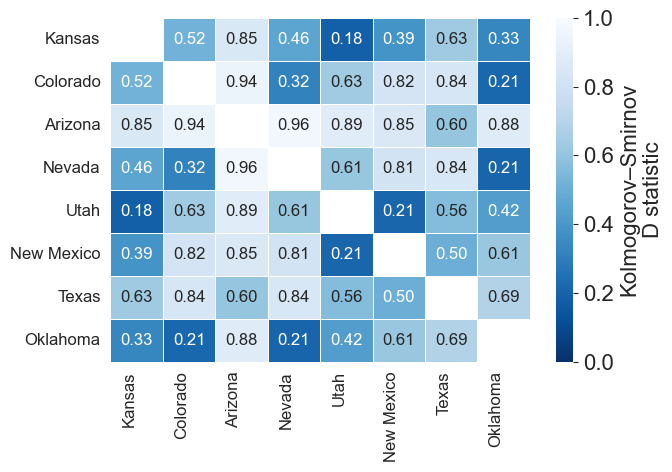

In [28]:
#################################################################################################
# Quantitative measures of different in the KDEs - estimating
#################################################################################################

# Dictionary of state data
states_cwb_dict = {
    'Kansas': df_ks['value'].dropna(),
    'Colorado': df_co['value'].dropna(),
    'Arizona': df_az['value'].dropna(),
    'Nevada': df_nv['value'].dropna(),
    'Utah': df_ut['value'].dropna(),
    'New Mexico': df_nm['value'].dropna(),
    'Texas': df_tx['value'].dropna(),
    'Oklahoma': df_ok['value'].dropna()
}

D_stat = ks_test_pairwise(state_dfs_dict=states_cwb_dict, round_digits=3)
D_stat = D_stat.apply(pd.to_numeric, errors='coerce')

# plotting
plot_heatmap(df=D_stat,
             title=None,  # 'Kolmogorov–Smirnov D-statistics Between States',
             fontsize=12,
             cmap='Blues_r',
             cbar_label='Kolmogorov–Smirnov\nD statistic',
             savepath = '../../Model_run/plots/D_stat_CWB.jpg',
             figsize=(7, 5))

-----------------------------------
# Consumptive irrigation data compilation and data extraction for each state

### Creating consumptive irrigation (irrigated crop ET - Peff) raster
`This needs to be done only once.`

In [7]:
# #################################################################################################
# # Creating consumptive irrigation (irrigated crop ET - Peff) raster
# ################################################################################################# 

# et_dir = f'../../Data_main/rasters/Irrigated_cropET/WestUS_grow_season'
# peff_dir =  f'../../Data_main/rasters/Effective_precip_prediction_WestUS/v19_grow_season_scaled'
# output_dir = f'../../Data_main/rasters/Consumptive_irrigation'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for year in list(range(2000, 2021)):
#     et, file = read_raster_arr_object(os.path.join(et_dir, f'Irrigated_cropET_{year}.tif'))
#     peff = read_raster_arr_object(os.path.join(peff_dir, f'effective_precip_{year}.tif'), get_file=False)

#     # calculate consumptive irrigation
#     consumptive_irr = np.where(~np.isnan(et) & ~np.isnan(peff), et - peff, -9999)
#     consumprive_irr = np.where((consumptive_irr != -9999) & (consumptive_irr < 0), 0, consumptive_irr)
    
#     # save
#     output_raster = os.path.join(output_dir, f'Consmp_Irr_{year}.tif')
#     write_array_to_raster(consumprive_irr, file, file.transform, output_raster)

### data extraction by state

In [8]:
# basins used in training + validation
basin_dict = {'KS': ['../../Data_main/shapefiles/Basins_of_interest/GMD3.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/GMD4.shp'],
              
              'CO': ['../../Data_main/shapefiles/Basins_of_interest/Republican_Basin.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/Rio_Grande_Basin.shp'],
              
              'AZ': ['../../Data_main/shapefiles/Basins_of_interest/Harquahala_INA.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/Douglas_AMA.shp',
                     '../../Data_main/shapefiles/Basins_of_interest/SantaCruz_AMA.shp'],
              
              'NV': ['../../Data_main/shapefiles/Basins_of_interest/Diamond_Valley_Basin.shp'],
              
              'UT': ['../../Data_main/shapefiles/Basins_of_interest/Parowan_Valley.shp',
                    '../../Data_main/shapefiles/Basins_of_interest/Cedar_Valley.shp',
                    '../../Data_main/shapefiles/Basins_of_interest/Beryl_Valley.shp'],
              
              'CA': ['../../Data_main/shapefiles/Basins_of_interest/Central_Valley.shp']
             }


#################################################################################################
# managing shapefiles for basins of interest
#################################################################################################
for state in basin_dict.keys():
    basin_list = basin_dict[state]

    # if multiple basins are considered in a state
    if len(basin_list) > 1:
        gdf = gpd.GeoDataFrame()  # empty geodataframe to compile all basins in a state

        # merging multiple basins into one for each state
        for i in range(len(basin_list)):
            merged_gdf = pd.concat([gdf, gpd.read_file(basin_list[i])], axis=0)

            gdf = merged_gdf

        merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
        merged_gdf = merged_gdf.dissolve()

        temp_shape = 'temp.shp'
        merged_gdf.to_file(temp_shape)
        input_shape = temp_shape

    # if a single multiple basin is considered in a state
    else:
        input_shape = basin_dict[state][0]

        
#################################################################################################
# masking raster for each state's basins
#################################################################################################
    consmp_irr_rasters = glob(os.path.join(f'../../Data_main/rasters/Consumptive_irrigation', '*.tif'))
    
    for ras in consmp_irr_rasters:
        mask_raster_by_shape(input_raster=ras, input_shape=input_shape, 
                             output_dir=f'../../Data_main/rasters/Consumptive_irrigation/{state}',
                             raster_name = os.path.basename(ras), 
                             band_names=None,
                             crop=True, filled=True, invert=False,
                             nodata=no_data_value)
    
    # removing the temporary shapefile for the inner loop
    for f in glob(os.path.splitext(temp_shape)[0] + '.*'):
        os.remove(f)

#################################################################################################
# collecting pixel data into dataframe from masked rasters
#################################################################################################

empty_dict = {state: [] for state in basin_dict.keys()}  # empty dict to store values by state

for state in basin_dict.keys():
    basin_irr_rasters = glob(os.path.join(f'../../Data_main/rasters/Consumptive_irrigation/{state}', '*.tif'))

    for ras in basin_irr_rasters:
        arr = read_raster_arr_object(ras, get_file=False).flatten()
        arr = arr[~np.isnan(arr)]
        empty_dict[state].extend(arr)

C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 21819956149 of field Shape_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 21820149683 of field area_m2 of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Perimeter' to 'Perimete_1'
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Area' to 'Area_1'
  ogr_write(
C:\Users\fahim\anaconda3\envs\westus_gw\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 980633835.28999996 of field AREA of feature 0 not successfully written. Possibly due

In [11]:
#################################################################################################
# creating separate dataframe for each state in empty_dict
#################################################################################################

# Kansas
df_ks2 = pd.DataFrame({'value': empty_dict['KS']})  
df_ks2 = df_ks2[df_ks2['value'] > 0]

# Colorado
df_co2 = pd.DataFrame({'value': empty_dict['CO']})  
df_co2 = df_co2[df_co2['value'] > 0]

# Arizona
df_az2 = pd.DataFrame({'value': empty_dict['AZ']})  
df_az2 = df_az2[df_az2['value'] > 0]

# Nevada
df_nv2 = pd.DataFrame({'value': empty_dict['NV']})  
df_nv2 = df_nv2[df_nv2['value'] > 0]

# Utah
df_ut2 = pd.DataFrame({'value': empty_dict['UT']})  
df_ut2 = df_ut2[df_ut2['value'] > 0]

# California
df_ca2 = pd.DataFrame({'value': empty_dict['CA']})  
df_ca2 = df_ca2[df_ca2['value'] > 0]

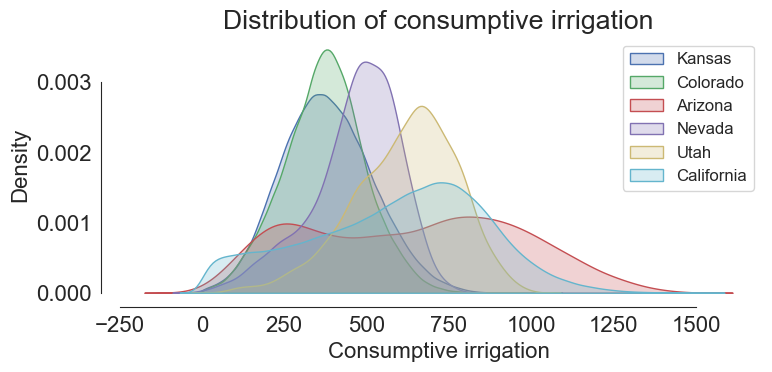

In [12]:
#################################################################################################
# plotting KDEs
#################################################################################################

fig, ax = plt.subplots(figsize=(8, 4))

sns.set_style("white")        # removes gridlines
fig.patch.set_facecolor("white")
plt.rcParams['font.size'] = '16'

# Define consistent colors
colors = {
    'Kansas': '#4C72B0',
    'Colorado': '#55A868',
    'Arizona': '#C44E52',
    'Nevada': '#8172B2',
    'Utah': '#CCB974',
    'California': '#64B5CD'
}

# Plot KDEs
sns.kdeplot(df_ks2['value'], ax=ax, fill=True, color=colors['Kansas'], label='Kansas')
sns.kdeplot(df_co2['value'], ax=ax, fill=True, color=colors['Colorado'], label='Colorado')
sns.kdeplot(df_az2['value'], ax=ax, fill=True, color=colors['Arizona'], label='Arizona')
sns.kdeplot(df_nv2['value'], ax=ax, fill=True, color=colors['Nevada'], label='Nevada')
sns.kdeplot(df_ut2['value'], ax=ax, fill=True, color=colors['Utah'], label='Utah')
sns.kdeplot(df_ca2['value'], ax=ax, fill=True, color=colors['California'], label='California')


# Labels and formatting
ax.set_xlabel('Consumptive irrigation')
ax.set_ylabel('Density')
ax.set_title('Distribution of consumptive irrigation')
ax.tick_params(axis='both')
ax.legend(prop={'size': 12})
sns.despine(offset=10, trim=True)
plt.tight_layout()
plt.show()

- `Comsumptive irrigation water use distributions overlaps is California and Arizona. Arizona's pumping data is considered in model training, however, Arizona's CWB doesn't fully match with California's. Therfreo, even though the irrigation signature in California and Arizona matches, the model can't correctly capture pumping in California.`